In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,precision_score
from sklearn.preprocessing import MinMaxScaler
from warnings import filterwarnings
filterwarnings(action='ignore')

In [2]:
df = pd.read_csv('/content/winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [3]:
duplicate = df.duplicated()
print(duplicate.sum())
df[duplicate]

240


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
4,7.4,0.700,0.00,1.90,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
11,7.5,0.500,0.36,6.10,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,5
27,7.9,0.430,0.21,1.60,0.106,10.0,37.0,0.99660,3.17,0.91,9.5,5
40,7.3,0.450,0.36,5.90,0.074,12.0,87.0,0.99780,3.33,0.83,10.5,5
65,7.2,0.725,0.05,4.65,0.086,4.0,11.0,0.99620,3.41,0.39,10.9,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1563,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1564,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1567,7.2,0.695,0.13,2.00,0.076,12.0,20.0,0.99546,3.29,0.54,10.1,5
1581,6.2,0.560,0.09,1.70,0.053,24.0,32.0,0.99402,3.54,0.60,11.3,5


In [4]:
df.drop_duplicates(inplace = True)

<Axes: ylabel='quality'>

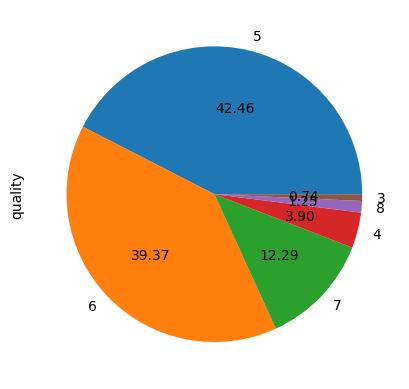

In [5]:
df['quality'].value_counts().plot(kind = 'pie' , autopct='%0.2f')

In [6]:
df['quality'] = [1 if val >=7 else 0 for val in df['quality']]

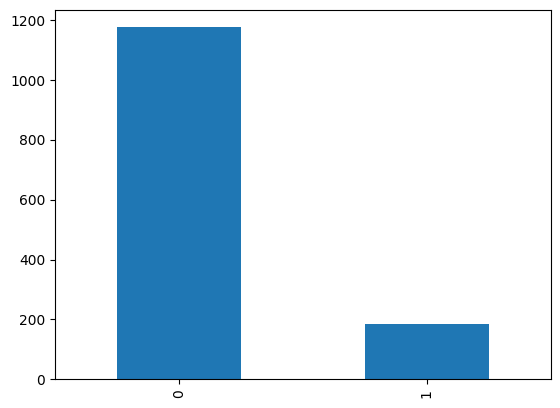

In [7]:
df['quality'].value_counts().plot(kind = 'bar')
plt.show()

In [8]:
def cap_data(df):
    df_copy = df.copy()
    for col in df_copy.columns:
        print("capping the", col)
        if df_copy[col].dtype in [float, int]:  # No need for separate checks
            percentiles = df_copy[col].quantile([0.25, 0.75]).values
            df_copy[col][df_copy[col] <= percentiles[0]] = percentiles[0]
            df_copy[col][df_copy[col] >= percentiles[1]] = percentiles[1]
    return df_copy

In [9]:
final_df = cap_data(df[['fixed acidity','volatile acidity','citric acid','residual sugar','chlorides','free sulfur dioxide','total sulfur dioxide','density','pH','sulphates','alcohol']])
final_df['quality'] = df['quality'].copy()

capping the fixed acidity
capping the volatile acidity
capping the citric acid
capping the residual sugar
capping the chlorides
capping the free sulfur dioxide
capping the total sulfur dioxide
capping the density
capping the pH
capping the sulphates
capping the alcohol


In [10]:
items = []

for col in final_df.drop('quality', axis=1).columns:
    items.append(df[col].mean())

items_array = np.array(items).reshape(1, -1)

ingredient_dataframe = pd.DataFrame(items_array, columns=final_df.drop('quality', axis=1).columns)
ingredient_dataframe

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.310596,0.529478,0.272333,2.5234,0.088124,15.893304,46.825975,0.996709,3.309787,0.658705,10.432315


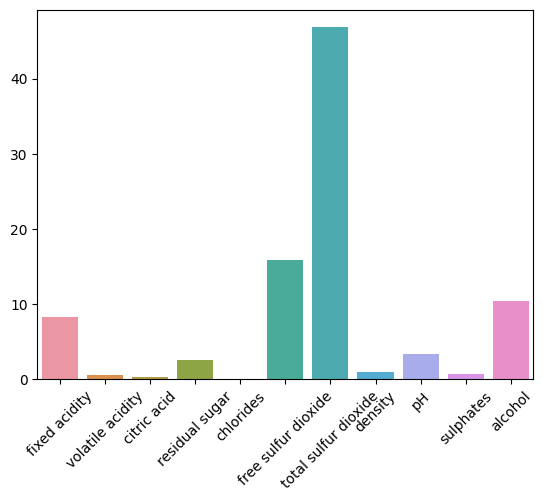

In [11]:
ax = sns.barplot(data=ingredient_dataframe)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.show()

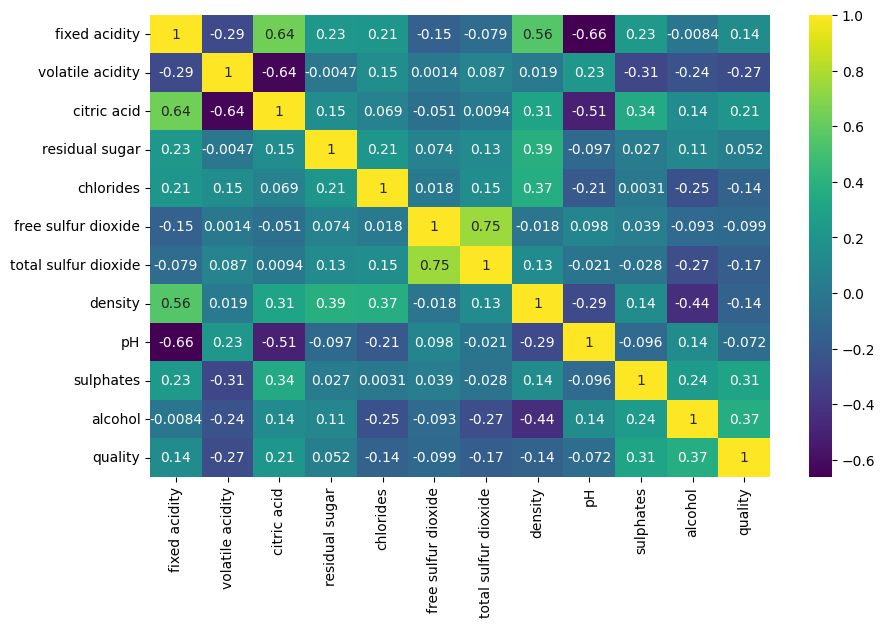

In [13]:
plt.figure(figsize=(10, 6))
sns.heatmap(final_df.corr(), annot=True, cmap='viridis')
plt.show()


In [14]:
X_train , X_test , y_train , y_test = train_test_split(final_df.drop(['quality'] , axis = 1) ,
                                                       final_df['quality'] , random_state=45 ,
                                                       test_size=0.1)

In [15]:
# It will remove the first feature that is correlated with anything other feature

def correlation(dataset , threshold):

     # Input validation
    if not isinstance(dataset, pd.DataFrame):
        raise ValueError("Input 'dataset' must be a pandas DataFrame.")
    if not (-1 <= threshold <= 1):
        raise ValueError("Threshold must be between -1 and 1.")

    col_corr = set() # set of all the names of correlated column
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i,j]) > threshold:
                colname = corr_matrix.columns[i] # Getting the name of the colummn
                col_corr.add(colname)
    return col_corr

In [16]:
corr_features = correlation(X_train , 0.8)
len(set(corr_features))

0

In [17]:
scaler = MinMaxScaler()
X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)

In [20]:
pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.2 MB/s eta 0:00:00


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier,RandomForestClassifier,IsolationForest,BaggingClassifier,ExtraTreesClassifier,GradientBoostingClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

In [22]:
svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
ifc = IsolationForest(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
etc = ExtraTreesClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)
cat = CatBoostClassifier(n_estimators=50,random_state=2)
lgb = LGBMClassifier(n_estimators=50,random_state=2)

In [23]:
classifiers = {
    'SVC' : svc,
    'KN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'ifc': ifc,
    'AdaBoost': abc,
    'BgC': bc,
    'ETC': etc,
    'GBDT':gbdt,
    'xgb':xgb,
    'cat':cat,
    'lgb':lgb
}

In [24]:
def train_classifier(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')

    return accuracy, precision


In [25]:
accuracy_scores = []
precision_scores = []

for name,clf in classifiers.items():

    current_accuracy,current_precision = train_classifier(clf, X_train_trf,y_train,X_test_trf,y_test)

    print("For ",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For  SVC
Accuracy -  0.7720588235294118
Precision -  0.77805239742956
For  KN
Accuracy -  0.9191176470588235
Precision -  0.9170312753200455
For  NB
Accuracy -  0.8823529411764706
Precision -  0.7785467128027681
For  DT
Accuracy -  0.8970588235294118
Precision -  0.8970588235294118
For  LR
Accuracy -  0.9117647058823529
Precision -  0.9073563851770218
For  RF
Accuracy -  0.8823529411764706
Precision -  0.8700189753320683
For  ifc
Accuracy -  0.0
Precision -  0.0
For  AdaBoost
Accuracy -  0.9117647058823529
Precision -  0.9117647058823529
For  BgC
Accuracy -  0.8897058823529411
Precision -  0.8867606546750931
For  ETC
Accuracy -  0.875
Precision -  0.8649155722326455
For  GBDT
Accuracy -  0.8970588235294118
Precision -  0.8869386464263124
For  xgb
Accuracy -  0.8897058823529411
Precision -  0.8811389471360777
Learning rate set to 0.175109
0:	learn: 0.6095490	total: 48.7ms	remaining: 2.38s
1:	learn: 0.5463367	total: 49.8ms	remaining: 1.2s
2:	learn: 0.4987047	total: 50.9ms	remaining: 798m

In [26]:
performance_df = pd.DataFrame({'Algorithm':classifiers.keys(),'Accuracy':accuracy_scores , 'Precision':precision_scores})
performance_df

,Algorithm,Accuracy,Precision
0,SVC,0.772059,0.778052
1,KN,0.919118,0.917031
2,NB,0.882353,0.778547
3,DT,0.897059,0.897059
4,LR,0.911765,0.907356
5,RF,0.882353,0.870019
6,ifc,0.000000,0.000000
7,AdaBoost,0.911765,0.911765
8,BgC,0.889706,0.886761
9,ETC,0.875000,0.864916


In [27]:
performance_df1 = pd.melt(performance_df, id_vars = "Algorithm")
performance_df1

,Algorithm,variable,value
0,SVC,Accuracy,0.772059
1,KN,Accuracy,0.919118
2,NB,Accuracy,0.882353
3,DT,Accuracy,0.897059
4,LR,Accuracy,0.911765
5,RF,Accuracy,0.882353
6,ifc,Accuracy,0.000000
7,AdaBoost,Accuracy,0.911765
8,BgC,Accuracy,0.889706
9,ETC,Accuracy,0.875000


In [28]:
X = final_df.iloc[: , :11]
y = final_df.iloc[: , -1]

In [29]:
from sklearn.ensemble import VotingClassifier

In [30]:
voting = VotingClassifier(estimators=[
    ('AdaBoost', abc),
    ('KN', knc),
    ('cat',cat)
],voting='soft')

In [31]:
voting.fit(X_train_trf , y_train)
y_pred = voting.predict(X_test_trf)
print('Accuracy Score is ::',accuracy_score(y_test , y_pred))
print('Cross Val Score is ::',np.mean(cross_val_score(voting , X , y , scoring='accuracy' , cv = 5))) #85

Learning rate set to 0.175109
0:	learn: 0.6095490	total: 924us	remaining: 45.3ms
1:	learn: 0.5463367	total: 1.99ms	remaining: 47.7ms
2:	learn: 0.4987047	total: 2.86ms	remaining: 44.8ms
3:	learn: 0.4601700	total: 3.79ms	remaining: 43.5ms
4:	learn: 0.4304117	total: 5ms	remaining: 45ms
5:	learn: 0.4019515	total: 5.51ms	remaining: 40.4ms
6:	learn: 0.3821320	total: 6.53ms	remaining: 40.1ms
7:	learn: 0.3642696	total: 7.4ms	remaining: 38.9ms
8:	learn: 0.3499192	total: 8.54ms	remaining: 38.9ms
9:	learn: 0.3360945	total: 9.3ms	remaining: 37.2ms
10:	learn: 0.3274360	total: 10.1ms	remaining: 35.9ms
11:	learn: 0.3176992	total: 11.5ms	remaining: 36.4ms
12:	learn: 0.3098309	total: 12.6ms	remaining: 35.8ms
13:	learn: 0.3015097	total: 13.7ms	remaining: 35.2ms
14:	learn: 0.2945209	total: 14.8ms	remaining: 34.5ms
15:	learn: 0.2883442	total: 15.9ms	remaining: 33.7ms
16:	learn: 0.2838811	total: 17ms	remaining: 33.1ms
17:	learn: 0.2785106	total: 17.9ms	remaining: 31.8ms
18:	learn: 0.2741958	total: 18.9ms	r

In [32]:
from sklearn.ensemble import StackingClassifier

In [33]:
stacking = StackingClassifier(estimators=[
    ('AdaBoost', abc),
    ('GBDT',gbdt),
    ('KN', knc)
],final_estimator=cat)

In [34]:
stacking.fit(X_train_trf , y_train)
y_pred = stacking.predict(X_test_trf)
print('Accuracy Score is ::',accuracy_score(y_test , y_pred))
print('Cross Val Score is ::',np.mean(cross_val_score(voting , X , y , scoring='accuracy' , cv = 5))) #0.8594557195571955

Learning rate set to 0.175109
0:	learn: 0.5957641	total: 1.31ms	remaining: 64.1ms
1:	learn: 0.5267142	total: 3.16ms	remaining: 75.9ms
2:	learn: 0.4756400	total: 4.88ms	remaining: 76.5ms
3:	learn: 0.4352951	total: 7.18ms	remaining: 82.5ms
4:	learn: 0.4053952	total: 8.33ms	remaining: 75ms
5:	learn: 0.3807601	total: 12.8ms	remaining: 93.5ms
6:	learn: 0.3616175	total: 13.8ms	remaining: 84.9ms
7:	learn: 0.3458543	total: 15.2ms	remaining: 79.7ms
8:	learn: 0.3335301	total: 16.6ms	remaining: 75.5ms
9:	learn: 0.3240492	total: 20.1ms	remaining: 80.5ms
10:	learn: 0.3156970	total: 21.1ms	remaining: 74.7ms
11:	learn: 0.3090292	total: 22ms	remaining: 69.7ms
12:	learn: 0.3042588	total: 24.2ms	remaining: 68.8ms
13:	learn: 0.2998518	total: 25.2ms	remaining: 64.9ms
14:	learn: 0.2964942	total: 26.2ms	remaining: 61.2ms
15:	learn: 0.2939483	total: 29.2ms	remaining: 62ms
16:	learn: 0.2914111	total: 29.9ms	remaining: 58ms
17:	learn: 0.2893261	total: 30.8ms	remaining: 54.8ms
18:	learn: 0.2878364	total: 32.9ms